In [ ]:
import os
# !pip install shutil
import shutil
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
!pip install git+https://github.com/albumentations-team/albumentations
import albumentations as A
!pip install imgaug
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
from PIL import Image
# if have trouble installing/importing albumentations package , 
# try updating pip: pip install --upgrade pip
import cv2
tf.config.run_functions_eagerly(True)
AUTOTUNE = tf.data.AUTOTUNE


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-3loen2b_
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-3loen2b_
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! python --version

Python 3.7.13


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#set path to cervAI folder shortcut within local gdrive
project_folder = os.path.join('content/drive/MyDrive','cerv_AI')
project_folder = '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi'
#set working directory to project/data folder
#os.chdir(project_folder)
data_folder = os.path.join(project_folder,'Data')
raw_data_folder = os.path.join(project_folder,'Data/raw')
os.chdir(raw_data_folder)

In [ ]:
#set data directory paths
cervix93_edf_dir = os.path.join(raw_data_folder,'cervix_93/cervix_93/EDF')
os.chdir(cervix93_edf_dir)

In [ ]:
#split images and csvs into two lists
images = []
csvs = []
for elem in os.listdir(os.getcwd()):
  temp_path = os.path.join(cervix93_edf_dir,elem)
  if elem.split('.')[-1] == 'png':
    images.append(temp_path)
  elif elem.split('.')[-1] == 'csv':
    csvs.append(temp_path)
  else:
    raise valueError('invalid selection')


In [ ]:
#sort lists to make sure indexes in each list are for the same image/csv file
csvs_sorted = sorted(csvs)
images_sorted = sorted(images)
for x in range(5):
  print(csvs_sorted[x])
  print(images_sorted[x])

/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/EDF/frame000.csv
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/EDF/frame000.png
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/EDF/frame001.csv
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/EDF/frame001.png
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/EDF/frame002.csv
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/EDF/frame002.png
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervi

In [ ]:
test_df = pd.read_csv(csvs_sorted[0],header=None)
test_df.head()
len(test_df.values)

28

In [ ]:
#get csv contents, save to arrays, pad (add zeros to end) so that all arrays have the same input length (set to maximum csv length)

#function to get x and y values from nested array
def get_x_y_vals(pandas_df_vals):
  x_vals , y_vals = np.hsplit(pandas_df_vals, 2)[0].flatten() , np.hsplit(pandas_df_vals, 2)[1].flatten()
  return x_vals, y_vals

problem_csvs = []
def get_all_x_y(csv_list,remove_bad_values):
  '''
  input: sorted list of paths to csv files, remove_bad_values as boolean
  output: list of x val arrays , list of y val arrays
  
  '''
  csv_lengths = []
  csv_contents = []
  x_vals_list = []
  y_vals_list = []

  #loop through csvs
  for csv in csv_list:
    with open(csv,'r') as csv_open: #open each csv
      temp_contents = pd.read_csv(csv_open, header=None).values #get values of nucleus points from csv
      # print(temp_contents)
      csv_contents.append(temp_contents) #add csv contents to list
      csv_lengths.append(len(temp_contents)) #add csv length to list
      temp_x_all , temp_y_all = get_x_y_vals(temp_contents) #get x and y values

      #check for x and y values greater than the image size , return array of indexes of invalid x values , indexes array of invalid y values
      index_problem_x = []
      index_problem_y = []
      valid_xs = []
      valid_ys =[]

      if remove_bad_values == True:
        #loop through rows in csv and check if they are valid values
        for z in range(len(temp_x_all)):
          if (temp_x_all[z] > 1280) or (temp_y_all[z] > 960):
            if (temp_x_all[z] > 1280):
              index_problem_x.append(z)
            elif (temp_y_all[z] > 960):
              index_problem_y.append(z)
          else:
            valid_xs.append(temp_x_all[z])
            valid_ys.append(temp_y_all[z])
        if (index_problem_x == []) and (index_problem_y == []):
          pass
        else:
          problem_csvs.append([csv.split('/')[-1],index_problem_x,index_problem_y])
            
        #append x and y vals to lists
        x_vals_list.append(valid_xs) 
        y_vals_list.append(valid_ys)
      else:
        x_vals_list.append(temp_x_all) 
        y_vals_list.append(temp_y_all)
      
  print('num points in each csv file')
  print(csv_lengths)
  max_points_in_csv = max(csv_lengths)
  print(f'max points in csv: {max_points_in_csv}')

  return x_vals_list,y_vals_list,max_points_in_csv

all_x , all_y, max_points_in_csv = get_all_x_y(csvs_sorted, remove_bad_values=False)




num points in each csv file
[28, 54, 29, 20, 50, 17, 39, 7, 37, 22, 45, 37, 40, 48, 49, 90, 36, 7, 15, 6, 15, 33, 13, 18, 9, 13, 25, 37, 17, 53, 22, 53, 11, 67, 14, 44, 18, 47, 40, 26, 50, 13, 30, 46, 41, 19, 83, 24, 17, 26, 39, 12, 14, 23, 18, 18, 24, 19, 17, 14, 13, 17, 39, 54, 46, 106, 15, 29, 53, 32, 77, 24, 33, 32, 18, 58, 23, 8, 26, 16, 17, 12, 13, 8, 8, 5, 9, 13, 21, 12, 25, 23, 22]
max points in csv: 106


(960, 1280, 3)


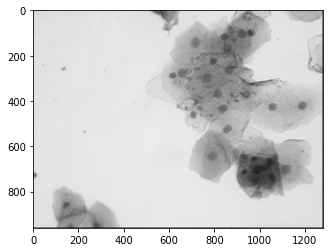

(960, 1280, 3)


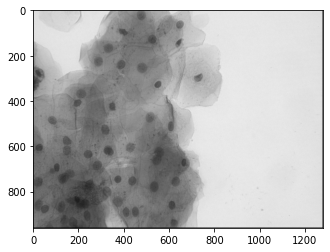

(960, 1280, 3)


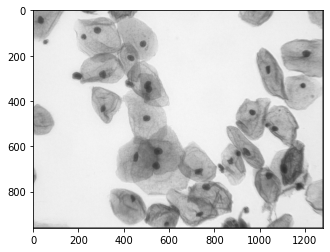

(960, 1280, 3)


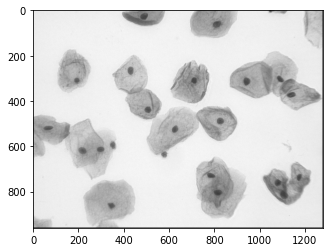

(960, 1280, 3)


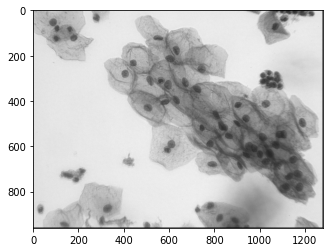

In [ ]:
#check some images
for x in range(len(images_sorted[0:5])):
  plt.figsize = (20,20)
  img = cv2.imread(images_sorted[x])
  dimensions = img.shape
  print(dimensions)
  plt.imshow(img[:,:] ,vmin=0, vmax=1, cmap='gray')
  plt.show()

In [ ]:
#format keypoints as expected by albumentations package
'''
keypoints = [
    (264, 203),
    (86, 88),
    (254, 160),
    (193, 103),
    (65, 341),
]
'''
keypoints_formatted_list = []
#loop through padded x and y arrays and convert keypoints into standard format
for z in range(len(all_x)):
  temp_x = all_x[z]
  temp_y = all_y[z]
  keypoints_formatted = list(zip(temp_x,temp_y)) #zip x and y and make into a list
  keypoints_formatted_list.append(keypoints_formatted)
  z+=1

len(keypoints_formatted_list)

93

In [ ]:
#expand training data
EXPANDED_DATASET_SIZE = 500
zipped_list = list(zip(images_sorted,keypoints_formatted_list))
new_indices = np.random.choice(np.arange(len(images_sorted)), EXPANDED_DATASET_SIZE, replace=True)
expanded_images = []
expanded_keypoints = []
for x in new_indices:
  expanded_images.append(images_sorted[x])
  expanded_keypoints.append(keypoints_formatted_list[x])



In [ ]:
expanded_images[0]

'/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/EDF/frame047.png'

In [ ]:
#transform images and keypoints at the same time
from google.colab.patches import cv2_imshow
from PIL import Image
#make image mask:
def make_mask(input_image_array,points_to_mask_array,coord_offset):
  '''
  expects co-ords in format
  [(53, 1148),
  (66, 699),
  (222, 93)]
  '''
  image_dims = np.shape(input_image_array)
  mask = np.zeros(image_dims)
  x=0
  for coord in points_to_mask_array:
    temp_x = int(coord[0])
    temp_y = int(coord[1])
    #loop through points, select a square of points according to the offset, change colour to red
    mask[temp_x-coord_offset:temp_x+coord_offset,temp_y-coord_offset:temp_y+coord_offset] = (0,0,255)
    # print(f'mask {x} edited')
    x+=1

  return mask

def make_mask_binary(input_image_array,points_to_mask_array,coord_offset):
  '''
  expects co-ords in format
  [(53, 1148),
  (66, 699),
  (222, 93)]
  '''
  image_dims = np.shape(input_image_array)
  height = image_dims[0]
  width = image_dims[1]
  mask = np.zeros((height,width)) #ignore colour dim
  x=0
  for coord in points_to_mask_array:
    temp_x = int(coord[0])
    temp_y = int(coord[1])
    #loop through points, select a square of points according to the offset, change colour to black
    mask[temp_x-coord_offset:temp_x+coord_offset,temp_y-coord_offset:temp_y+coord_offset] = 255
    # print(f'mask {x} edited')
    x+=1

  return mask


def display_mask(input_image,mask_image,opacity):
  alpha = opacity
  combined_img = np.uint(input_image*alpha + mask_image*(1-alpha))
  cv2_imshow(combined_img)

# def display_binary_mask(input_image,bin_mask_image,opacity):
#   alpha = opacity
#   combined_img = cv2.addWeighted(input_image, alpha, bin_mask_image, 0.5, 0.5)
#   cv2_imshow(combined_img)


input_image = cv2.imread(images_sorted[0])
print(keypoints_formatted_list[0])
print(input_image.shape)
# nucleus_mask = make_mask(input_image,keypoints_formatted_list[0],20)
# display_mask(input_image,nucleus_mask,0.5)

nucleus_mask_bin = make_mask_binary(input_image,keypoints_formatted_list[0],20)
# display_binary_mask(input_image,nucleus_mask_bin,0.5)

[(103, 964), (104, 919), (120, 846), (146, 718), (166, 856), (227, 796), (263, 866), (280, 655), (287, 617), (300, 769), (371, 814), (377, 940), (421, 1191), (425, 1055), (436, 840), (460, 709), (523, 856), (641, 792), (649, 930), (652, 978), (677, 1045), (699, 1014), (700, 1116), (714, 933), (714, 987), (732, 1052), (751, 984), (861, 146)]
(960, 1280, 3)


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1641: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


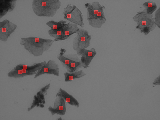

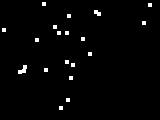

output image dims: (120, 160, 3)


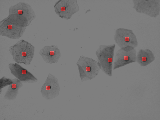

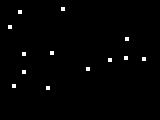

output image dims: (120, 160, 3)


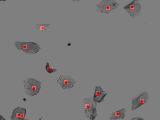

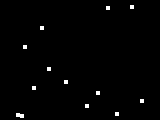

output image dims: (120, 160, 3)


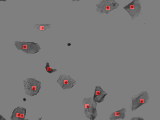

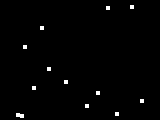

output image dims: (120, 160, 3)


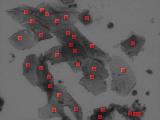

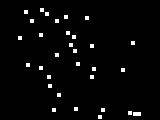

output image dims: (120, 160, 3)


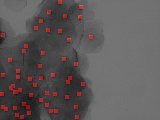

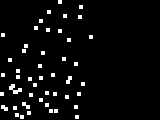

output image dims: (120, 160, 3)


In [ ]:
def transform_image_keypoints(input_image_path,keypoints):
  '''
  inputs: path to image file, keypoints formatted in the manner expected by albumentations
  outputs: transformed image, transformed keypoints
  '''
  transform = A.Compose([
      # A.HorizontalFlip(p=0.5),
      # A.VerticalFlip(p=0.5),
      # A.Rotate(limit=20,border_mode=cv2.BORDER_CONSTANT),
      A.RandomContrast(limit=(0.2),p=0.5),
      A.Resize(120,160)], #height, width
    keypoint_params=A.KeypointParams(format='xy',remove_invisible=False))
  
  input_image = cv2.imread(input_image_path)
  transformed = transform(image=input_image, keypoints=keypoints)
  transformed_image = transformed['image']
  transformed_keypoints = transformed['keypoints']
  return transformed_image ,transformed_keypoints

#make all masks and show some images:
array_image_arrays = []
array_mask_arrays = []
array_bin_mask_arrays = []

for x in range(len(expanded_images)):
  transformed_image, transformed_keypoints = transform_image_keypoints(expanded_images[x],expanded_keypoints[x])
  array_image_arrays.append(np.asarray(transformed_image))
  
  # print(f'input image dims: {input_image.shape}')
  #make 3 channel mask
  trans_nucleus_mask_3chan = make_mask(transformed_image,transformed_keypoints,2)
  array_mask_arrays.append(np.asarray(trans_nucleus_mask_3chan))

  #make binary mask
  trans_nucleus_mask_bin = make_mask_binary(transformed_image,transformed_keypoints,2)
  array_bin_mask_arrays.append(np.asarray(trans_nucleus_mask_bin))

  if x <= 5:
    display_mask(transformed_image,trans_nucleus_mask_3chan,0.5)
    cv2_imshow(trans_nucleus_mask_bin)
    print(f'output image dims: {transformed_image.shape}')

  # if x > 5:
  #   break

  
  

In [ ]:
#convert to np arrays:
np_array_image_arrays = np.asarray(array_image_arrays)
np_array_mask_arrays = np.asarray(array_bin_mask_arrays)
print(np.shape(np_array_image_arrays))
print(np.shape(np_array_mask_arrays))


(500, 120, 160, 3)
(500, 120, 160)


## Help needed:

When only a resize is applied, the keypoint locations stay correct. However as soon as another type of transform is applied, the keypoints do not line up correctly with the transformed image.

In [ ]:
# expanded keypoints
#  [(50, 366),
#  (76, 348),
#  (453, 731),
#  (479, 476)]


# [x_min, y_min, x_max, y_max] , 
#To normalize values, we divide coordinates in pixels for the x- and y-axis by the width and the height of the image
bounding_boxs = []
offset = 10
for keypoints in expanded_keypoints:
  temp_bb_list = []
  for coord in keypoints:
    temp_x = int(coord[0])
    temp_y = int(coord[1])
    temp_bb = [(temp_x-offset),temp_y-offset,temp_x+offset,temp_y+offset]
    # print(temp_bb)
    temp_bb_list.append(np.asarray(temp_bb))
  bounding_boxs.append(temp_bb_list)

bb_array = np.asarray(bounding_boxs)  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
bb_array[0][0]

array([25, -1, 45, 19])

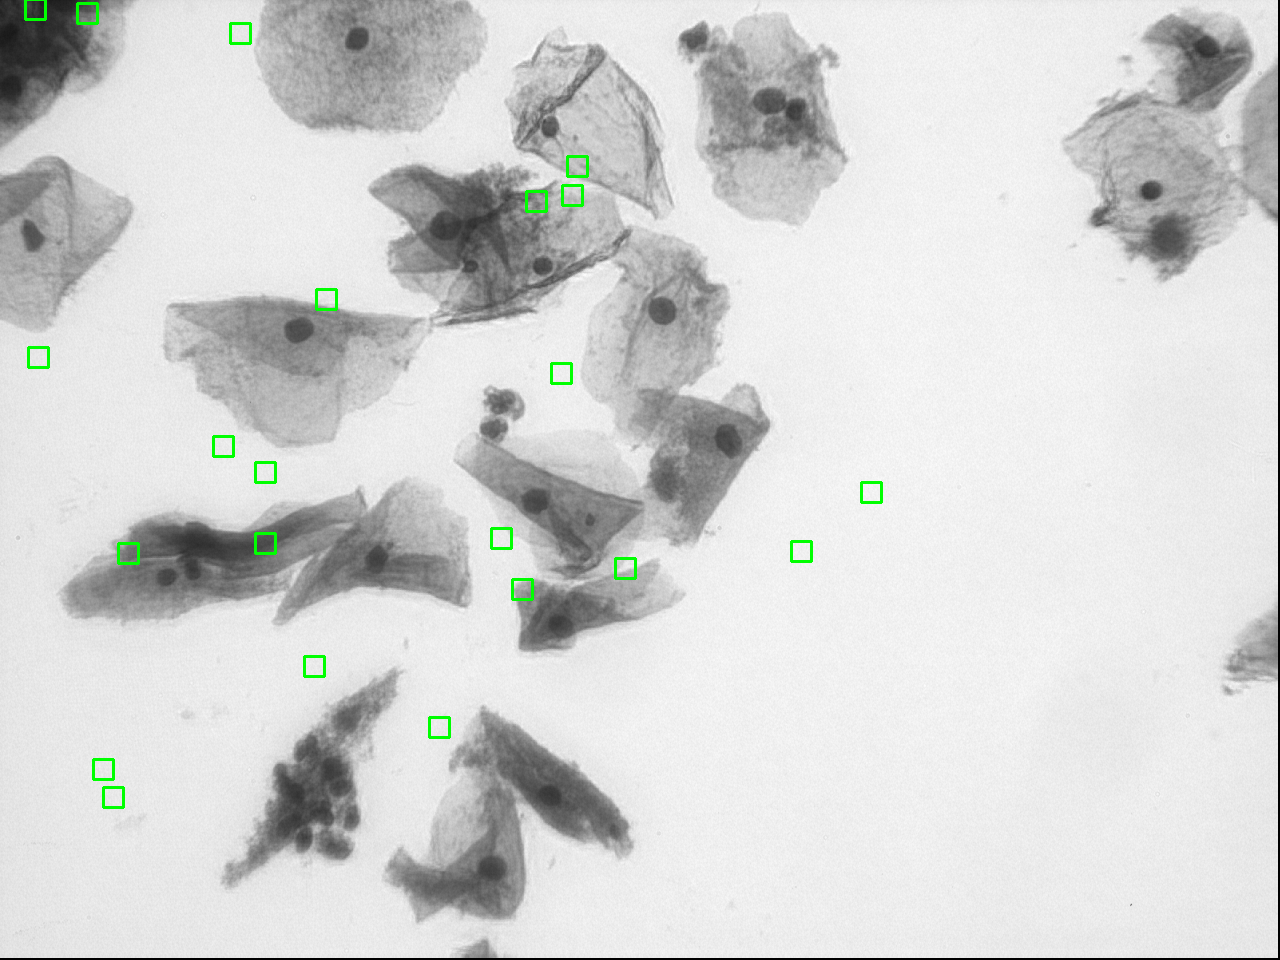

In [ ]:
# [temp_x-2,temp_y-2,temp_x+2,temp_y+2]
def vis_bounding_box(input_image_path, list_of_bb):
  image_out = cv2.imread(input_image_path)

  for bb in list_of_bb:
    image_out = cv2.rectangle(image_out, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 2)
  
  cv2_imshow(image_out)

vis_bounding_box(expanded_images[0], bb_array[0])



input keypoints [(103, 964), (104, 919), (120, 846), (146, 718), (166, 856), (227, 796), (263, 866), (280, 655), (287, 617), (300, 769), (371, 814), (377, 940), (421, 1191), (425, 1055), (436, 840), (460, 709), (523, 856), (641, 792), (649, 930), (652, 978), (677, 1045), (699, 1014), (700, 1116), (714, 933), (714, 987), (732, 1052), (751, 984), (861, 146)]
output keypoints [(294.0, 241.0), (293.75, 229.75), (289.75, 211.5), (283.25, 179.5), (278.25, 214.0), (263.0, 199.0), (254.0, 216.5), (249.75, 163.75), (248.0, 154.25), (244.75, 192.25), (227.0, 203.5), (225.5, 235.0), (214.5, 297.75), (213.5, 263.75), (210.75, 210.0), (204.75, 177.25), (189.0, 214.0), (159.5, 198.0), (157.5, 232.5), (156.75, 244.5), (150.5, 261.25), (145.0, 253.5), (144.75, 279.0), (141.25, 233.25), (141.25, 246.75), (136.75, 263.0), (132.0, 246.0), (104.5, 36.5)]


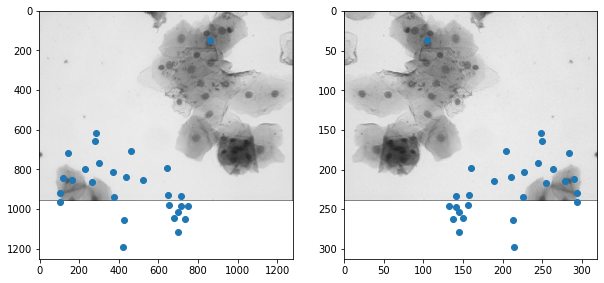

output image dims: (240, 320, 3)


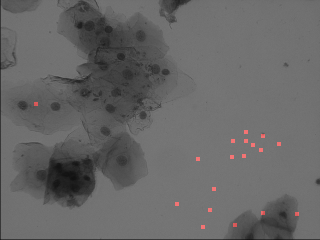

input keypoints [(22, 480), (62, 648), (96, 394), (128, 527), (143, 646), (169, 332), (227, 288), (240, 390), (253, 480), (280, 25), (298, 731), (327, 552), (373, 212), (410, 197), (427, 350), (472, 517), (485, 86), (514, 610), (528, 322), (574, 149), (604, 430), (606, 25), (617, 151), (625, 335), (626, 560), (635, 241), (660, 548), (674, 666), (683, 281), (694, 104), (710, 88), (722, 161), (739, 135), (743, 124), (745, 377), (752, 441), (755, 19), (757, 633), (764, 248), (780, 537), (800, 329), (833, 194), (845, 376), (857, 24), (857, 230), (861, 615), (870, 125), (873, 52), (890, 452), (892, 410), (909, 238), (925, 140), (937, 177), (940, 621)]
output keypoints [(314.25, 120.0), (304.25, 162.0), (295.75, 98.5), (287.75, 131.75), (284.0, 161.5), (277.5, 83.0), (263.0, 72.0), (259.75, 97.5), (256.5, 120.0), (249.75, 6.25), (245.25, 182.75), (238.0, 138.0), (226.5, 53.0), (217.25, 49.25), (213.0, 87.5), (201.75, 129.25), (198.5, 21.5), (191.25, 152.5), (187.75, 80.5), (176.25, 37.25), (

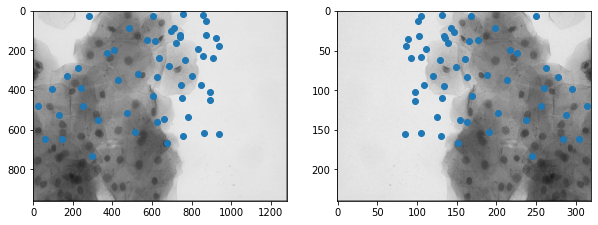

output image dims: (240, 320, 3)


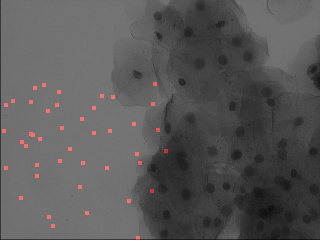

input keypoints [(44, 33), (89, 286), (118, 224), (150, 486), (193, 1206), (212, 430), (262, 1039), (286, 310), (329, 505), (334, 1192), (349, 512), (437, 309), (454, 968), (476, 501), (523, 1069), (622, 554), (623, 944), (634, 909), (645, 455), (664, 874), (685, 547), (697, 1106), (712, 728), (727, 1042), (774, 1176), (777, 764), (826, 440), (900, 737), (942, 591)]
output keypoints [(308.75, 8.25), (297.5, 71.5), (290.25, 56.0), (282.25, 121.5), (271.5, 301.5), (266.75, 107.5), (254.25, 259.75), (248.25, 77.5), (237.5, 126.25), (236.25, 298.0), (232.5, 128.0), (210.5, 77.25), (206.25, 242.0), (200.75, 125.25), (189.0, 267.25), (164.25, 138.5), (164.0, 236.0), (161.25, 227.25), (158.5, 113.75), (153.75, 218.5), (148.5, 136.75), (145.5, 276.5), (141.75, 182.0), (138.0, 260.5), (126.25, 294.0), (125.5, 191.0), (113.25, 110.0), (94.75, 184.25), (84.25, 147.75)]


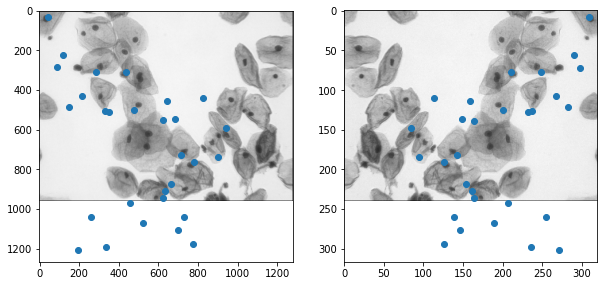

output image dims: (240, 320, 3)


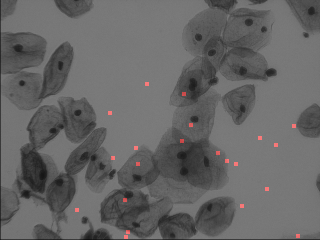

input keypoints [(28, 490), (64, 811), (266, 431), (304, 1088), (310, 192), (311, 713), (315, 944), (375, 1141), (440, 509), (492, 827), (519, 68), (523, 628), (615, 300), (621, 217), (728, 784), (737, 1174), (760, 1081), (805, 816), (813, 1107), (861, 348)]
output keypoints [(312.75, 122.5), (303.75, 202.75), (253.25, 107.75), (243.75, 272.0), (242.25, 48.0), (242.0, 178.25), (241.0, 236.0), (226.0, 285.25), (209.75, 127.25), (196.75, 206.75), (190.0, 17.0), (189.0, 157.0), (166.0, 75.0), (164.5, 54.25), (137.75, 196.0), (135.5, 293.5), (129.75, 270.25), (118.5, 204.0), (116.5, 276.75), (104.5, 87.0)]


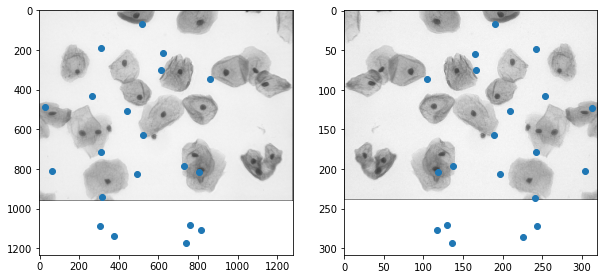

output image dims: (240, 320, 3)


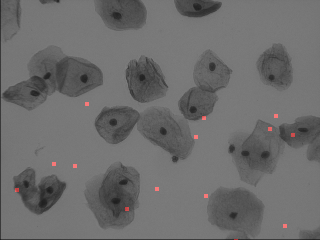

input keypoints [(53, 88), (73, 1072), (123, 552), (124, 178), (177, 631), (212, 605), (232, 441), (259, 743), (283, 407), (309, 516), (322, 674), (332, 599), (346, 725), (395, 633), (407, 581), (412, 1027), (419, 906), (431, 508), (460, 804), (479, 940), (499, 900), (499, 1191), (510, 831), (516, 846), (518, 747), (547, 1087), (547, 1107), (553, 864), (560, 1015), (591, 782), (592, 612), (598, 950), (600, 1072), (609, 977), (631, 1047), (637, 942), (637, 1002), (658, 1150), (667, 1025), (678, 795), (684, 913), (720, 1170), (734, 1133), (779, 1118), (781, 1175), (788, 1105), (877, 327), (913, 825), (927, 893), (947, 139)]
output keypoints [(306.5, 22.0), (301.5, 268.0), (289.0, 138.0), (288.75, 44.5), (275.5, 157.75), (266.75, 151.25), (261.75, 110.25), (255.0, 185.75), (249.0, 101.75), (242.5, 129.0), (239.25, 168.5), (236.75, 149.75), (233.25, 181.25), (221.0, 158.25), (218.0, 145.25), (216.75, 256.75), (215.0, 226.5), (212.0, 127.0), (204.75, 201.0), (200.0, 235.0), (195.0, 225.0), 

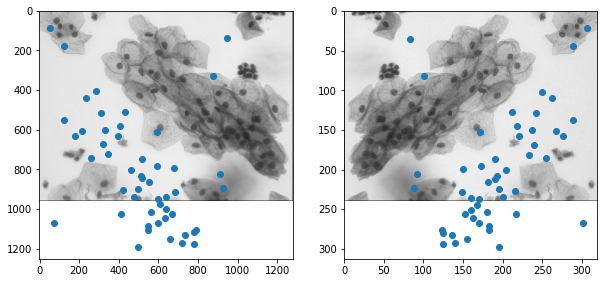

output image dims: (240, 320, 3)


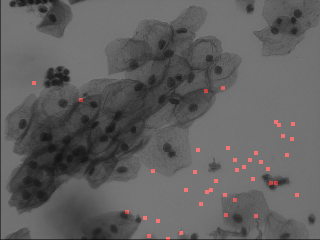

In [ ]:
#does not work correctly
#https://albumentations.ai/docs/getting_started/keypoints_augmentation/

transform = A.Compose([
      A.HorizontalFlip(p=1),
      #A.VerticalFlip(p=1),
      # A.Rotate(limit=90,border_mode=cv2.BORDER_CONSTANT)
      A.Resize(240,320)] #height, width
    ,keypoint_params=A.KeypointParams(format='xy',remove_invisible=False))

def transform_image_keypoints2(input_image_path,input_keypoints,transform_in):
  '''
  inputs: path to image file, keypoints formatted in the manner expected by albumentations
  outputs: transformed image, transformed keypoints
  '''
  
  input_image = cv2.imread(input_image_path) 
  transformed = transform_in(image=input_image, keypoints=input_keypoints)
  transformed_image = transformed['image'] #get the transformed image
  transformed_keypoints = transformed['keypoints'] #get the transformed keypoints
  print(f'input keypoints {input_keypoints}')
  print(f'output keypoints {transformed_keypoints}')

  
  temp_x_in, temp_y_in = list(zip(*input_keypoints))  #separate input keypoints into x and y
  temp_x_out, temp_y_out = list(zip(*transformed_keypoints)) #separate transformed keypoints into x and y

  #visualise transforms
  fig = plt.figure(figsize=(10,5))
  fig.add_subplot(1, 2, 1)
  plt.imshow(input_image,origin='upper')
  plt.scatter(temp_x_in,temp_y_in)
  fig.add_subplot(1, 2, 2)
  plt.imshow(transformed_image,origin='upper')
  plt.scatter(temp_x_out,temp_y_out)
  plt.show()
  return transformed_image ,transformed_keypoints

#show some images:
for x in range(5):
  transformed_image,transformed_keypoints = transform_image_keypoints2(images_sorted[x],keypoints_formatted_list[x],transform)

  # print(f'input image dims: {input_image.shape}')
  print(f'output image dims: {transformed_image.shape}')

  trans_nucleus_mask = make_mask(transformed_image,transformed_keypoints,2)
  display_mask(transformed_image,trans_nucleus_mask,0.5)

output image dims: (240, 320, 3)


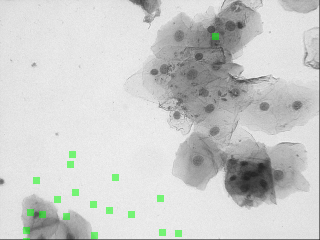

output image dims: (240, 320, 3)


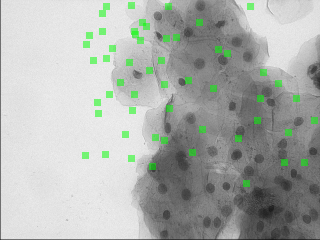

output image dims: (240, 320, 3)


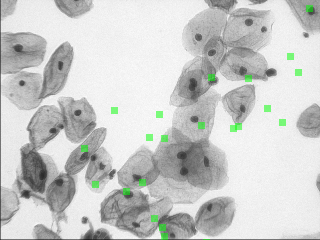

output image dims: (240, 320, 3)


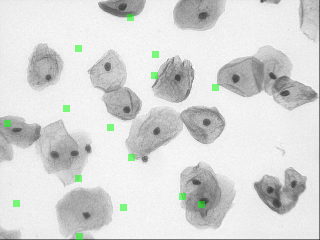

output image dims: (240, 320, 3)


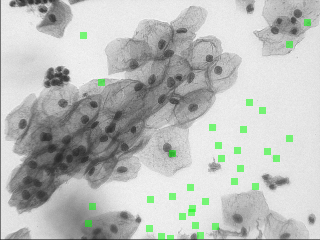

In [ ]:
#does not work correctly
#https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html
def transform_image_keypoints_imaug(input_image_path,input_keypoints):
  '''
  inputs: path to image file, keypoints formatted in the manner expected by albumentations
  outputs: transformed image, transformed keypoints

  need keypoints in format:
  kps = KeypointsOnImage([
    Keypoint(x=65, y=100),
    Keypoint(x=75, y=200),
    Keypoint(x=100, y=100),
    Keypoint(x=200, y=80)
  '''
  input_image = cv2.imread(input_image_path)
  kps_list = []

  for x in range(len(input_keypoints)):
    kps_list.append(Keypoint(input_keypoints[x][0],input_keypoints[x][1])) #create keypoint object with x and y co-ords
  kps = KeypointsOnImage(kps_list,shape=input_image.shape)
        
  #define transforms
  seq = iaa.Sequential([
      iaa.Resize(size={"height":240, "width":320}),
      iaa.Fliplr(0.5)])
  
  
  transformed_image, transformed_keypoints = seq(image=input_image, keypoints=kps)
  return transformed_image ,transformed_keypoints, kps

#show some images:
for x in range(5):
  transformed_image,transformed_keypoints, kps_obj = transform_image_keypoints_imaug(images_sorted[x],keypoints_formatted_list[x])

  # print(f'input image dims: {input_image.shape}')
  print(f'output image dims: {transformed_image.shape}')

  # image_before = kps_obj.draw_on_image(cv2.imread(images_sorted[x]), size=7)
  # cv2_imshow(image_before)
  image_after = transformed_keypoints.draw_on_image(transformed_image, size=7,alpha=0.5)
  cv2_imshow(image_after)
  
  # trans_nucleus_mask = make_mask(transformed_image,transformed_keypoints,2)
  # display_mask(transformed_image,trans_nucleus_mask,0.5)

## Make train test splits

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val_test, y_train, y_val_test = train_test_split(np_array_image_arrays,np_array_mask_arrays, train_size = 0.8, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, train_size = 0.5, random_state=42, shuffle=True)


In [ ]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_val))
print(np.shape(y_val))
print(np.shape(x_test))
print(np.shape(y_test))

(400, 120, 160, 3)
(400, 120, 160)
(50, 120, 160, 3)
(50, 120, 160)
(50, 120, 160, 3)
(50, 120, 160)


In [ ]:
# def parse_image(filename):
  
#     image1 = tf.io.read_file(filename) #read filename
#     image2 = tf.io.decode_png(image1, channels=3) #convert from png greyscale
#     image3 = tf.image.resize(image2,[120, 160])
#     image4 = image3/255
#     return image4

# #wrap parse image function as tensorflow function for opimisation
# def tf_parse_image(input):
#   y = tf.numpy_function(parse_image, [input],tf.float16) 
#   return y 

#create tf dataset
def create_tf_dataset(images_array, masks_array):
  # filenames_ds = tf.data.Dataset.from_tensor_slices(filepaths)
  images_array = images_array/255
  masks_array = masks_array/255
  # images_ds = tf.data.Dataset.from_tensor_slices(images_array/255)
  # masks_ds = tf.data.Dataset.from_tensor_slices(masks_array/255)
  ds_out = tf.data.Dataset.from_tensor_slices((images_array, masks_array))
  # ds_out = tf.data.Dataset.zip((images_ds, masks_ds))
  #ds_out = tf.data.Dataset.from_tensor_slices((images_ds, labels_ds))
  return ds_out

#we can speed up image loading by optimising the back-end processes
def configure_for_performance(ds,batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=64)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def make_tf_datasets(x_train,y_train,x_val,y_val,x_test,y_test,BATCH_SIZE):
  '''
  inputs: takes x inputs as list of filepaths , y inputs as associated image label, and batch_size
  returns: optimised tensorflow datasets to be loaded into ML model
  '''
  train_ds = create_tf_dataset(x_train,y_train)
  train_ds_opt = configure_for_performance(train_ds,BATCH_SIZE)
  valid_ds = create_tf_dataset(x_val,y_val)
  valid_ds_opt = configure_for_performance(valid_ds,BATCH_SIZE)
  # if (x_test == None) or (y_test ==None):
  #   print('train and valid ds created')
  #   return train_ds_opt , valid_ds_opt
  # else:
  test_ds_opt = create_tf_dataset(x_test,y_test)
  #   print('train/valid/test ds created')
  return train_ds_opt ,valid_ds_opt, test_ds_opt

BATCH_SIZE=32
train_ds_opt , valid_ds_opt, test_ds = make_tf_datasets(x_train, y_train, x_val, y_val, x_test, y_test, BATCH_SIZE=BATCH_SIZE)

In [ ]:
# x = 0
# for image,mask in train_ds_opt.unbatch():
#   print(np.shape(image))
#   print(np.shape(mask))
#   display_mask(image*255,mask*255,0.5)
#   x+=1
#   if x > 5:
#     break

## Define u-net model

https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-u-net-for-image-segmentation-with-tensorflow-and-keras.md

https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

U net attempt 2

In [ ]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate, CenterCrop

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_shape, n_filters = 32, dropout = 0.05, batchnorm = True):
  input_data = tf.keras.Input(shape=input_shape)

  # Contracting Path
  c1 = conv2d_block(input_data, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  c1_across = CenterCrop(height = 112, width= 160)(c1)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  c2_across = CenterCrop(height = 56, width= 80)(c2)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)
  
  c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  c3_across = CenterCrop(height = 28, width= 40)(c3)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  c4_across = CenterCrop(height = 14, width= 20)(c4)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
  
  # Expansive Path
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = Concatenate(axis=3)([u6, c4_across])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  
  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = Concatenate(axis=3)([u7, c3_across])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  
  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = Concatenate(axis=3)([u8, c2_across])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  
  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = Concatenate(axis=3)([u9, c1_across])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

  #final upsample to get close to correct output image dims
  u10 = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(c9)

  o1 = Conv2D(1, (5, 5), activation='sigmoid')(u10) #was sigmoid
  # o2 = tf.keras.layers.Resizing(height=120,width=160,interpolation='bilinear')(o1)
  # o2 = MaxPooling2D((3, 3))(o1)
  o2 = CenterCrop(height = 120, width= 160)(o1)
  model = tf.keras.Model(inputs=[input_data], outputs=[o2])
  model.summary()
  # print(tf.shape(outputs))
  return model

unet_model = get_unet(input_shape=(120,160,3))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 120, 160, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 120, 160, 32  128        ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [ ]:
callback1 = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=10, verbose=0, mode='auto',
      baseline=None, restore_best_weights=True)

In [ ]:
from keras import backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

class Jac(tf.keras.losses.Loss):
  def call(self,y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred, smooth=100):        
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

class DiceLoss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    return dice_coef_loss(y_true, y_pred)


In [ ]:
# tf.keras.backend.clear_session()
# unet_model.compile(optimizer='adam',
#                   loss=tf.keras.losses.BinaryFocalCrossentropy(
#                     gamma=20.0,
#                     from_logits=True,
#                     axis=-1),
#                   metrics=tf.keras.metrics.IoU(
#                     num_classes = 2,
#                     target_class_ids= [1]))

tf.keras.backend.clear_session()
unet_model.compile(optimizer='adam',
                  loss=DiceLoss(),
                  metrics=tf.keras.metrics.IoU(
                    num_classes = 2,
                    target_class_ids= [1]))

# jac_loss = Jac()
# unet_model.compile(optimizer='adam',
#                 loss=jac_loss,
#                 metrics=tf.keras.metrics.MeanIoU(2))

In [ ]:
EPOCHS=100

history = unet_model.fit(
    train_ds_opt,
    validation_data=valid_ds_opt,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callback1)
    # class_weight = {0:1, 1:20}) #give more weight to positive values correct than zeroes

Epoch 1/100
13/13 - 3s - loss: -5.4268e-01 - io_u: 0.3306 - val_loss: -3.6976e-01 - val_io_u: 0.2007 - 3s/epoch - 209ms/step
Epoch 2/100
13/13 - 3s - loss: -5.3297e-01 - io_u: 0.3311 - val_loss: -3.5685e-01 - val_io_u: 0.2017 - 3s/epoch - 204ms/step
Epoch 3/100
13/13 - 3s - loss: -5.3796e-01 - io_u: 0.3345 - val_loss: -3.7662e-01 - val_io_u: 0.1958 - 3s/epoch - 206ms/step
Epoch 4/100
13/13 - 3s - loss: -5.3992e-01 - io_u: 0.3328 - val_loss: -3.7433e-01 - val_io_u: 0.1972 - 3s/epoch - 206ms/step
Epoch 5/100
13/13 - 3s - loss: -5.3760e-01 - io_u: 0.3314 - val_loss: -3.5726e-01 - val_io_u: 0.1936 - 3s/epoch - 202ms/step
Epoch 6/100
13/13 - 3s - loss: -5.3028e-01 - io_u: 0.3322 - val_loss: -3.7168e-01 - val_io_u: 0.1996 - 3s/epoch - 202ms/step
Epoch 7/100
13/13 - 3s - loss: -5.4071e-01 - io_u: 0.3333 - val_loss: -3.7443e-01 - val_io_u: 0.1895 - 3s/epoch - 202ms/step
Epoch 8/100
13/13 - 3s - loss: -5.3365e-01 - io_u: 0.3345 - val_loss: -3.7264e-01 - val_io_u: 0.1999 - 3s/epoch - 202ms/step


In [ ]:
def probs_to_mask(probs):
	''' Convert Softmax output into mask. '''
	pred_mask = tf.argmax(probs, axis=2)
	return pred_mask

def generate_plot(img_input, mask_truth, probs):
	''' Generate a plot of input, truthy mask and probability mask. '''
	fig, axs = plt.subplots(1, 4)
	fig.set_size_inches(16, 6)

	# Plot the input image
	axs[0].imshow(img_input)
	axs[0].set_title("Input image")

	# Plot the truthy mask
	axs[1].imshow(mask_truth,vmin=0, vmax=1,cmap='Greys')
	axs[1].set_title("True mask")

	# Plot the predicted mask
	# predicted_mask = probs_to_mask(probs)
	axs[2].imshow(probs,vmin=0, vmax=1,cmap='Greys')
	axs[2].set_title("Predicted mask")

	# Plot the overlay
	# config = configuration()
	# img_input_resized = tf.image.resize(img_input, (config.get("mask_width"), config.get("mask_height")))
	axs[3].imshow(img_input,)
	axs[3].imshow(probs, alpha=0.5,vmin=0, vmax=1,cmap='Greys')
	axs[3].set_title("Overlay")

	# Show the plot
	plt.show()

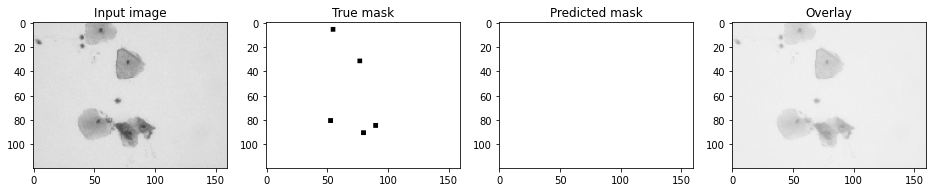

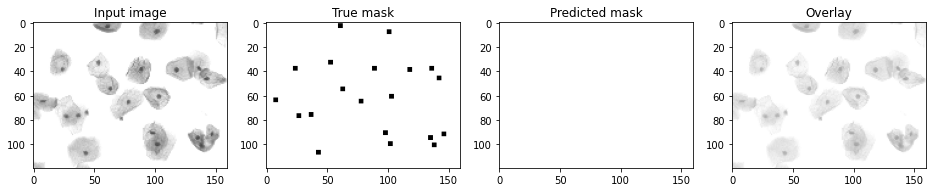

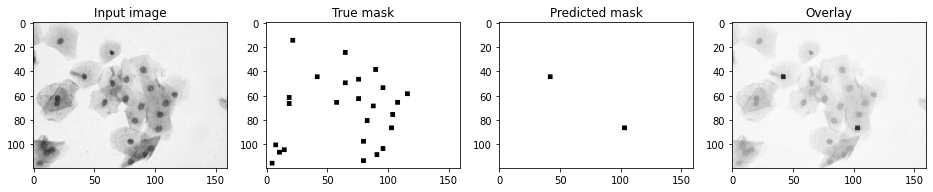

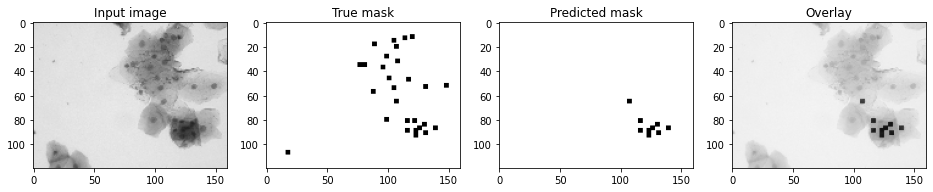

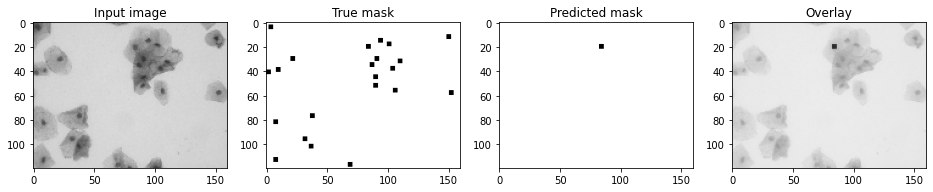

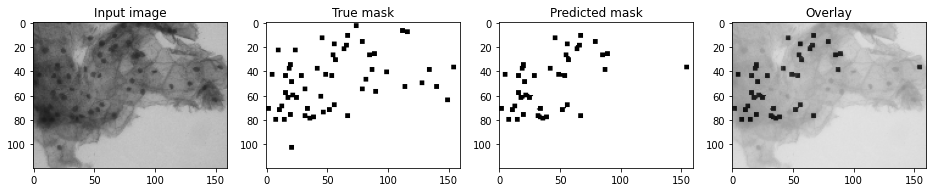

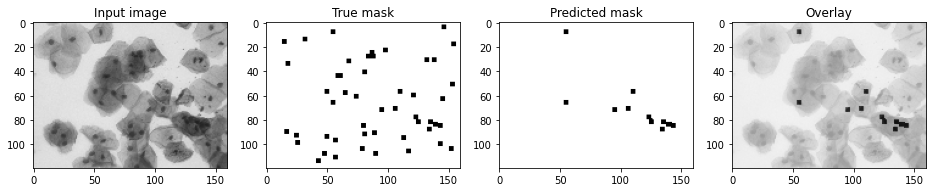

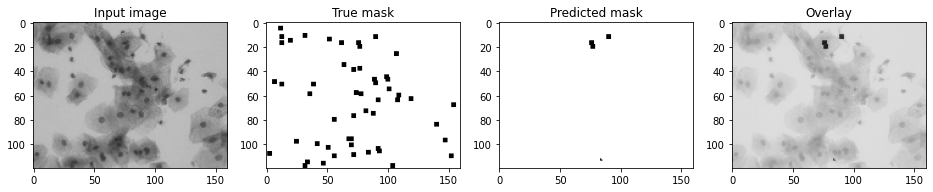

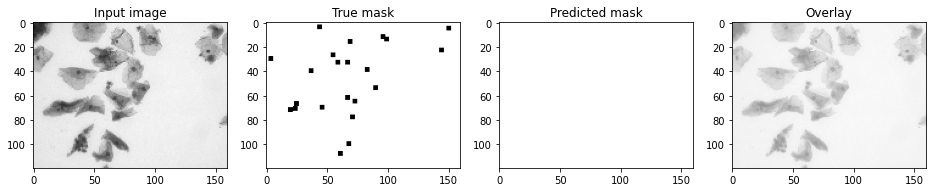

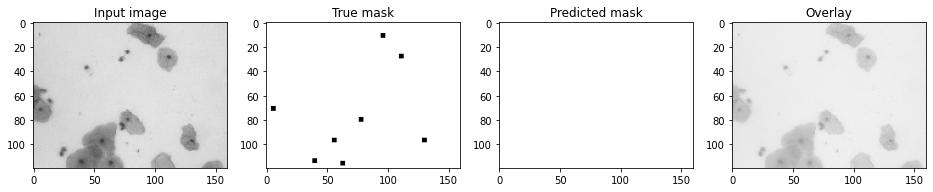

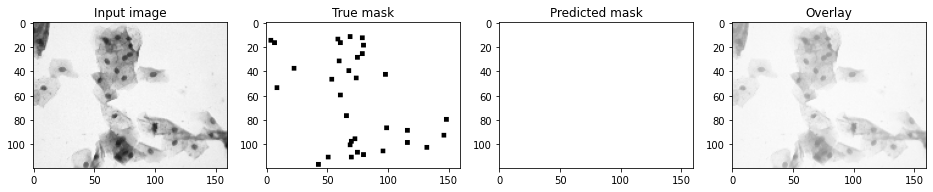

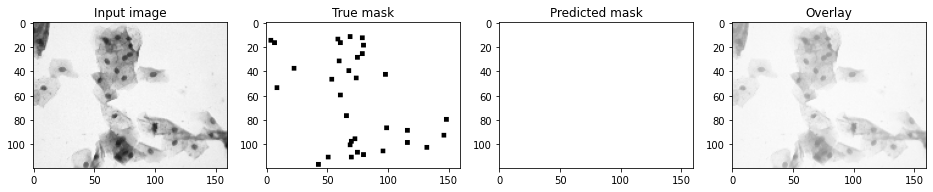

In [ ]:
np.set_printoptions(threshold=200)
for images, masks in valid_ds_opt.take(2):
  # Generate prediction for each image
  predicted_masks = unet_model.predict(images)
  predicted_masks_round = np.rint(predicted_masks)

  # Plot each image and masks in batch
  for index, (image, mask) in enumerate(zip(images, masks)):
    # print(mask)
    generate_plot(image, mask,np.squeeze(predicted_masks_round[index]))
    # cv2_imshow(predicted_masks[index]*255)
    if index > 4:
          break

In [ ]:
#check if any values are predicted to be 1
preds = np.asarray(predicted_masks)
rounded = np.rint(preds)
np.sum(rounded)

30187.0

In [ ]:
def show_training_metrics():
  mae = history.history['mae']
  val_acc = history.history['val_mae']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(loss))

  plt.figure(figsize=(8, 8))
  # plt.subplot(1, 2, 1)
  plt.plot(epochs_range, mae, label='Training MAE')
  plt.plot(epochs_range, val_acc, label='Validation MAE')
  plt.legend(loc='lower right')
  plt.title('Training MAE')
  plt.show()

  # plt.subplot(1, 2, 2)
  plt.figure(figsize=(8, 8))
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training Loss')
  plt.show()

show_training_metrics()



KeyError: ignored

In [ ]:
y_preds = []
y_preds.append(new_model.predict(valid_ds_opt))
y_preds_res = np.reshape(y_preds,(50,212))
def vis_preds():
  x = 0
  for image,labels in valid_ds_opt.unbatch():
    image_upscaled = image*255
    print(np.shape(image))
    temp_x = []
    temp_y = []
    temp_x_y = y_preds_res[x]
    for z in range(len(temp_x_y)):
      if z % 2 == 0: #add x vals to list
        temp_x.append(temp_x_y[z]*320)
      else:
        temp_y.append(temp_x_y[z]*240)


    #get x and y into format to make mask:
    temp_x_y_zipped = list(zip(temp_x,temp_y))
    print(f'zipped x y preds {temp_x_y_zipped }')
    temp_mask = make_mask(image_upscaled, temp_x_y_zipped,5)
    display_mask(image_upscaled, temp_mask,0.8)
    x+=1

    if x > 5:
      break
vis_preds()
print(np.shape(y_preds_res))

